In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

## Datasets

In [6]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset\ingr_map.pkl
./dataset\interactions_test.csv
./dataset\interactions_train.csv
./dataset\interactions_validation.csv
./dataset\PP_recipes.csv
./dataset\PP_users.csv
./dataset\RAW_interactions.csv
./dataset\RAW_recipes.csv


In [15]:
input_path = "./dataset/"

## RAW_INTERACTIONS.csv

In [16]:
df_raw_interactions = pd.read_csv(input_path + "RAW_interactions.csv")

In [17]:
df_raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


We see that the file RAW_interactions.csv contains information about the ratings of recipes by users of the Food.com platform. The evaluation is given both in numerical form (through the rating column) and in writing (through the review column).

## RAW_recipes.csv

In [18]:
df_raw_recipes = pd.read_csv(input_path + "RAW_recipes.csv")

In [19]:
df_raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


We see that the RAW_recipes.csv file contains various details about a recipe Specifically, information is provided about:

* The preparation time in minutes (see minutes column)
* Basic nutritional information, e.g. calories, fat, protein (see nutrition column)
* The ingredients needed for the recipe (see ingredients column)
* The number of ingredients (see column n_ingredients)
* The steps for its execution (see steps column)

**Ideas for the future**
* The information on the preparation time of a recipe can be combined with the information on the number of ingredients it requires, in order to suggest easy and quick recipes.
* The information of the ingredients needed by a recipe can be used in the scenario where the user selects (or enters) the ingredients at his disposal and wants recipes that include these ingredients.
* Nutritional information related to a recipe can be leveraged in the scenario where the user wants recipes e.g. with low calories due to dieting.

So at first glance, we see that the **RAW_recipes.csv** file provides enough information about a recipe to satisfy critical functional requirements of the application.

# Data preprocessing (for content-based filtering)

Based on the initial plan, we will implement a first draft in the direction of **content-based filtering** as a recommendation method. In this method we are interested in the grouping of "similar" objects, i.e. recipes in our case. Thus, we will attempt to properly process the recipe data (present in the RAW_recipes.csv file), so that given the name of a recipe, e.g. 5 similar recipes. This is the central idea behind content-based filtering and is a key component of the work.

In [20]:
df = pd.read_csv(input_path + "RAW_recipes.csv")

In [21]:
df['nutrition']

0               [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
1           [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]
2          [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]
3           [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]
4           [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]
                             ...                     
231632    [415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]
231633          [14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]
231634           [59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]
231635      [188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]
231636       [174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]
Name: nutrition, Length: 231637, dtype: object

The **nutrition** column includes nutritional information about:

* calories
* fat (total fat)
* sugar
* sodium
* protein
* saturated fat
* carbohydrates

It is necessary to isolate these categories in separate columns of the DataFrame, in order to be able to exploit the information they provide.

In [22]:
df['nutrition'] = df['nutrition'].apply(eval)

nutrition_columns = [
    'calories', 
    'total fat (PDV)', 
    'sugar (PDV)', 
    'sodium (PDV)', 
    'protein (PDV)', 
    'saturated fat (PDV)', 
    'carbohydrates (PDV)'
]

df[nutrition_columns] = pd.DataFrame(df['nutrition'].tolist(), index=df.index)

We remove the columns **id**, **contributor_id** and **submitted**, because they do not offer essential information about the recipe and in general about the recommendation process. Furthermore, it is emphasized that the **nutrition** column is also removed, because it is replaced by its individual components (calories, fat, sugar, etc.). Finally, we remove duplicate entries.

In [23]:
df = df.drop(['id', 'contributor_id', 'submitted', 'nutrition'], axis=1)
df = df.drop_duplicates()
df = df.dropna()

We take a first look at the processed dataset and notice that it contains the information related to one recipe and only that.

In [24]:
df.head()

,name,minutes,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,55,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,30,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,130,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,45,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,190,"['weeknight', 'time-to-make', 'course', 'main-...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


Below we see a summary of the statistical properties of the processed dataset. We point out that statistical properties are provided only for DataFrame columns that contain numeric values.

In [25]:
df.describe()

,minutes,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2.266570e+05,226657.000000,226657.000000,226657.000000,226657.000000,226657.000000,226657.000000,226657.000000,226657.000000,226657.000000
mean,9.602472e+03,9.773927,9.054170,471.662774,35.936406,83.447059,30.063581,34.600458,45.364816,15.450752
std,4.510715e+06,5.999824,3.740942,1194.845397,77.733347,807.100380,131.863087,58.483655,97.638329,82.482854
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+01,6.000000,6.000000,174.500000,8.000000,9.000000,5.000000,7.000000,7.000000,4.000000
50%,4.000000e+01,9.000000,9.000000,313.300000,20.000000,25.000000,15.000000,18.000000,23.000000,9.000000
75%,6.500000e+01,12.000000,11.000000,518.700000,41.000000,68.000000,33.000000,51.000000,52.000000,16.000000
max,2.147484e+09,145.000000,43.000000,434360.200000,17183.000000,362729.000000,29338.000000,6552.000000,10395.000000,36098.000000


Let's focus on the row named **min** of the table above. This line gives information about the minimum value of each column of the DataFrame. We notice that all columns have a minimum value of 0, except the **n_ingredients** column which has a minimum value of 1. However, every "valid" recipe has the following specifications:

* Requires non-zero brew time (**minutes > 0**)
* Requires at least 2 ingredients (**n_ingredients > 1**)
* Requires at least 2 brewing steps (**n_steps > 1**)
* Has a non-zero number of calories (**calories > 0**)
* Cannot have all nutritional information (**calories**) zero at the same time

The quality of the recommender is largely linked to the quality of the dataset it is trained on. Therefore, it is necessary to further process the DataFrame in order to ensure its validity according to the above criteria.

In [26]:
df_filtered = df.copy()

df_filtered = df_filtered[(
    df_filtered['minutes'] > 0) & 
    (df_filtered['n_ingredients'] > 1) & 
    (df_filtered['n_steps'] > 1) & 
    (df_filtered['calories'] > 0)
]

df_filtered = df_filtered[~(
    (df_filtered['total fat (PDV)'] == 0) & 
    (df_filtered['sugar (PDV)'] == 0) & 
    (df_filtered['sodium (PDV)'] == 0) & 
    (df_filtered['protein (PDV)'] == 0) & 
    (df_filtered['saturated fat (PDV)'] == 0) & 
    (df_filtered['carbohydrates (PDV)'] == 0)
)]

In [27]:
df_filtered.describe()

,minutes,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2.229340e+05,222934.000000,222934.000000,222934.000000,222934.000000,222934.000000,222934.000000,222934.000000,222934.00000,222934.000000
mean,9.756526e+03,9.886074,9.108584,474.267085,36.167431,83.635556,29.887177,34.930136,45.68911,15.526914
std,4.548223e+06,5.960141,3.728739,1201.606049,77.894856,813.319435,129.412033,58.717577,97.57604,83.088682
min,1.000000e+00,2.000000,2.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000e+01,6.000000,6.000000,177.200000,8.000000,9.000000,5.000000,7.000000,7.00000,4.000000
50%,4.000000e+01,9.000000,9.000000,316.000000,21.000000,25.000000,15.000000,19.000000,23.00000,9.000000
75%,6.500000e+01,12.000000,11.000000,521.000000,41.000000,68.000000,33.000000,51.000000,53.00000,16.000000
max,2.147484e+09,145.000000,43.000000,434360.200000,17183.000000,362729.000000,29338.000000,6552.000000,10395.00000,36098.000000


We see that indeed the zero minimum values ​​in the **minutes**, **n_steps** and **calories** columns were removed. Also, the minimum value in the **ingredients** column is now 2 instead of 1.

In [28]:
print(f"Number of recipes before filtering: {len(df)}")
print(f"Number of recipes after filtering: {len(df_filtered)}")

num_recipes_removed = len(df) - len(df_filtered)
print(f"Number of recipes that were removed: {num_recipes_removed} ({round(100 * num_recipes_removed / len(df), 2)}%)")

Number of recipes before filtering: 226657
Number of recipes after filtering: 222934
Number of recipes that were removed: 3723 (1.64%)


For oversight purposes, we display the distributions of the DataFrame columns that take numeric values.

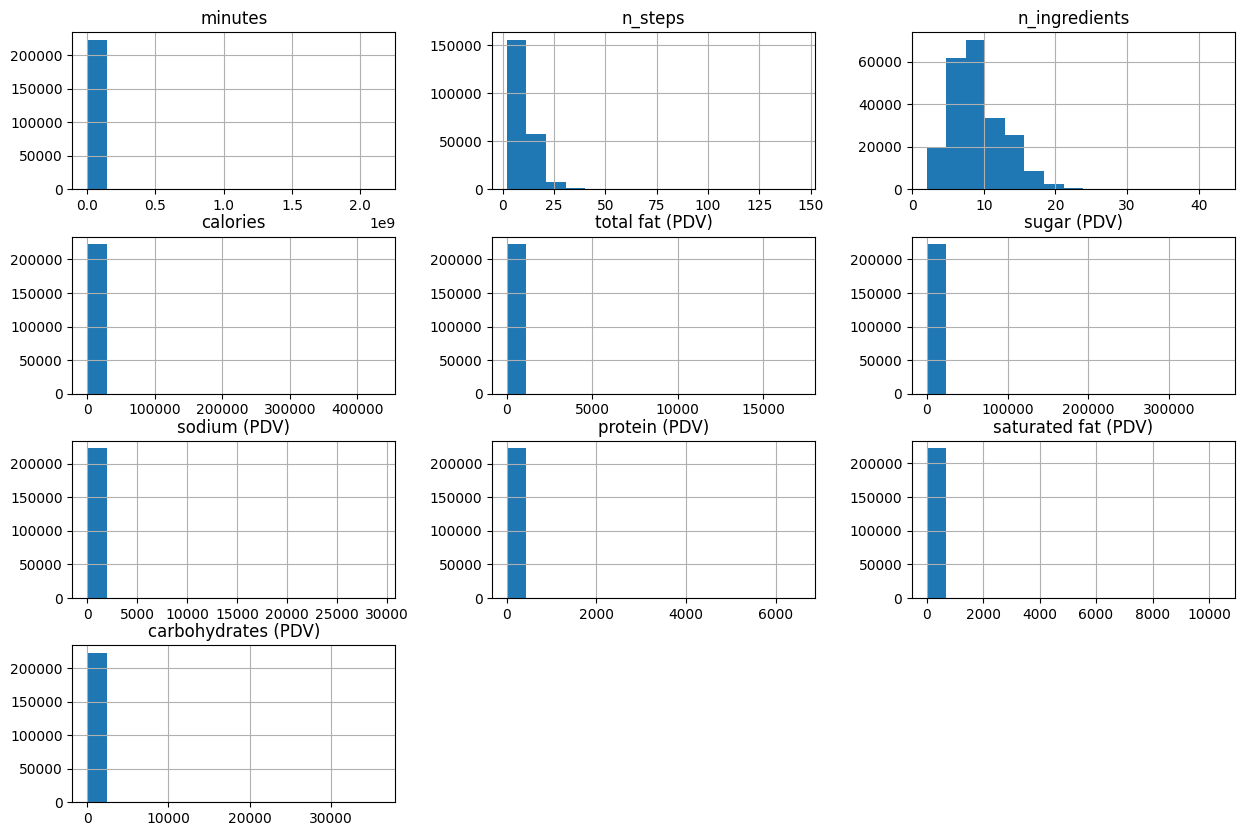

In [29]:
df_filtered.hist(bins = 15, figsize = (15, 10))

plt.show()

# Implementation of the recommender through content-based filtering

First, we will use the [TF-IFD vectorization](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) technique for feature extraction from the processed dataset.

The TF-IFD vectorization technique, through the `fit_transform()` method, analyzes a collection of documents and extracts critical information such as the vocabulary and the most important terms. This information is finally encoded in a sparse table (vector, hence the vectorization). It is understood that this method makes sense to be used only for text data.

Then, via the `transform()` method, a new document (in this case, the target recipe) is also encoded into an array, based on the extracted features (see `fit_transform()` method).

Finally, after all the data has been converted into an array that now contains numbers, we'll use cosine distance ([cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)) to hierarchically return the 5 ex . more similar recipes to the target recipe.

The important question is this:
* Which columns of the edited dataset will constitute the documents we mention above?

As we said, we are only interested in columns that contain text information. So, we will experiment with the **steps**, **description** and **ingredients** columns.

However, in addition to the above, there are still columns that provide valuable information about a recipe (eg **minutes**, **calories**) in numerical form. We will examine how we can utilize this kind of information, so that in combination with TF-IDF vectorization, we can produce good recommendations. For numerical features, the [Standard Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) technique will be applied, so that all values ​​are samples of the normal distribution (gaussian distribution), i.e. characterized by zero mean value and unit standard deviation.

Next, we will use various combinations of attributes for feature extraction to finally see which combination produces the best recommendations.

In [30]:
# Dictionary to hold vector reoresentations for the different sets of attributes during feature extraction
# The key is a string that indicates the corresponding set of attributes
vectors = {}

## steps

In [31]:
key = "steps"

combined_text = df_filtered['steps'].apply(lambda x: ' '.join(eval(x)))

# Define feature extraction process for text data 
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the text data
vectors[key] = tfidf_vectorizer.fit_transform(combined_text)

## steps + ingredients

In [32]:
key = "steps+ingredients"

combined_text = df_filtered['steps'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['ingredients'].apply(lambda x: ' '.join(eval(x)))

# Define feature extraction process for text data 
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the text data
vectors[key] = tfidf_vectorizer.fit_transform(combined_text)

## steps + ingredients + description

In [33]:
key = "steps+ingredients+description"

combined_text = df_filtered['steps'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['ingredients'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['description']

# Define feature extraction process for text data 
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the text data
vectors[key] = tfidf_vectorizer.fit_transform(combined_text)

## steps + ingredients + description + minutes

In [34]:
key = "steps+ingredients+description+minutes"

combined_text = df_filtered['steps'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['ingredients'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['description']
minutes = df_filtered['minutes']

# Create a new dataframe with the necessary features
df_tmp = pd.DataFrame({
    'combined_text': combined_text,
    'minutes': minutes
})

# Define feature extraction process for both text and numerical data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
scaler = StandardScaler()

# Create a column transformer to handle different types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'combined_text'),
        ('numeric', make_pipeline(SimpleImputer(strategy='mean'), scaler), ['minutes'])
    ]
)

# Apply the transformation
vectors[key] = preprocessor.fit_transform(df_tmp)

## steps + ingredients + description + minutes+ calories

In [35]:
key = "steps+ingredients+description+minutes+calories"

combined_text = df_filtered['steps'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['ingredients'].apply(lambda x: ' '.join(eval(x))) + ' ' + df_filtered['description']
minutes = df_filtered['minutes']
calories = df_filtered['calories']

# Create a new dataframe with the necessary features
df_tmp = pd.DataFrame({
    'combined_text': combined_text,
    'minutes': minutes,
    'calories': calories
})

# Define feature extraction process for both text and numerical data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
scaler = StandardScaler()

# Create a column transformer to handle different types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'combined_text'),
        ('numeric', make_pipeline(SimpleImputer(strategy='mean'), scaler), ['minutes', 'calories'])
    ]
)

# Apply the transformation
vectors[key] = preprocessor.fit_transform(df_tmp)

In [43]:
print(vectors["steps"])

  (0, 32126)	0.031210289959875993
  (0, 12207)	0.05574172044865993
  (0, 4976)	0.040292608307042406
  (0, 15730)	0.06282171023416183
  (0, 3673)	0.08669007515754014
  (0, 10714)	0.03837291205007312
  (0, 9771)	0.15571768795925042
  (0, 14997)	0.10663059207177504
  (0, 36501)	0.03851746134179801
  (0, 40062)	0.05592784240690058
  (0, 26029)	0.15571768795925042
  (0, 14330)	0.12397972473004534
  (0, 7243)	0.08827062432127583
  (0, 7875)	0.08734178642853913
  (0, 34115)	0.07881838616393007
  (0, 27883)	0.10904188868885271
  (0, 13602)	0.08785956312178377
  (0, 15892)	0.06499309819096762
  (0, 18808)	0.10798202121564236
  (0, 23878)	0.022943985366550127
  (0, 1757)	0.06707974484301628
  (0, 11975)	0.046486200843458794
  (0, 1498)	0.04856662472709571
  (0, 4950)	0.03314677678224311
  (0, 35115)	0.08643646670894375
  :	:
  (222933, 5015)	0.29927332219854813
  (222933, 41176)	0.30624129131925726
  (222933, 20899)	0.30039461546292645
  (222933, 33615)	0.3188916733560065
  (222933, 10356)	0.244